# Deep learning for forecasting of electricity wholesale price and energy demand(LSTM)

Data files:
dataset_train_4_0to200.csv (34639)

Temperature data for the Houston region – Weather API. Using a python code, collected the temperature data using API call from the server of the website.

ERCOT price data: From ercot website, taking real time wholesale electricity price for a specific zone i.e. Houston area for four entire years: 2015-2018. Temporal resolution is an hour.

ERCOT load data: From ercot website, historical load data for each weather zone in the ercot region is got. Houston comes in the coast zone.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# -*- coding: utf-8 -*-
import pandas as pd
load = pd.read_csv('./dataset_train_4_0to200.csv')

In [3]:
load.head


<bound method NDFrame.head of       Delivery Date  Delivery Hour Repeated Hour Flag Settlement Point Name  \
0          1/1/2015              1                  N            LZ_HOUSTON   
1          1/1/2015              2                  N            LZ_HOUSTON   
2          1/1/2015              3                  N            LZ_HOUSTON   
3          1/1/2015              4                  N            LZ_HOUSTON   
4          1/1/2015              5                  N            LZ_HOUSTON   
...             ...            ...                ...                   ...   
34633    12/31/2018             20                  N            LZ_HOUSTON   
34634    12/31/2018             21                  N            LZ_HOUSTON   
34635    12/31/2018             22                  N            LZ_HOUSTON   
34636    12/31/2018             23                  N            LZ_HOUSTON   
34637    12/31/2018             24                  N            LZ_HOUSTON   

      Settlement Poin

In [4]:
load['Settlement Point Type'].unique()

array(['LZ'], dtype=object)

In [5]:
load['DayStatus'].unique()

array(['Public Holiday', 'Weekday', 'Weekend'], dtype=object)

In [6]:
load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34638 entries, 0 to 34637
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Delivery Date           34638 non-null  object 
 1   Delivery Hour           34638 non-null  int64  
 2   Repeated Hour Flag      34638 non-null  object 
 3   Settlement Point Name   34638 non-null  object 
 4   Settlement Point Type   34638 non-null  object 
 5   DayStatus               34638 non-null  object 
 6   Temperature in F        34638 non-null  int64  
 7   Load in Houston         34638 non-null  float64
 8   Settlement Point Price  34638 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 2.4+ MB


In [7]:
print(load.describe())

       Delivery Hour  Temperature in F  Load in Houston  \
count   34638.000000      34638.000000     34638.000000   
mean       12.525348         69.285813     11792.815830   
std         6.919687         14.492037      2597.047989   
min         1.000000         24.000000      7261.200000   
25%         7.000000         60.000000      9953.645000   
50%        13.000000         72.000000     11148.325000   
75%        19.000000         80.000000     13203.805000   
max        24.000000        104.000000     20269.850000   

       Settlement Point Price  
count            34638.000000  
mean                23.937004  
std                 23.052486  
min                 -5.950000  
25%                 17.920000  
50%                 20.430000  
75%                 25.660000  
max               1930.320000  


In [8]:
load.isnull().sum()

Delivery Date             0
Delivery Hour             0
Repeated Hour Flag        0
Settlement Point Name     0
Settlement Point Type     0
DayStatus                 0
Temperature in F          0
Load in Houston           0
Settlement Point Price    0
dtype: int64

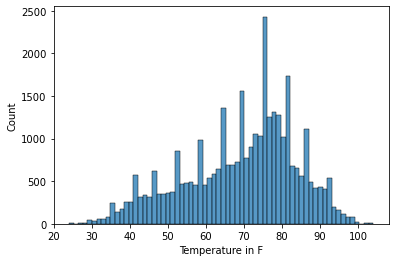

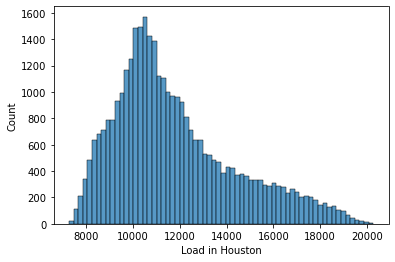

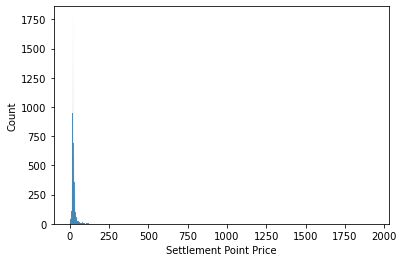

In [9]:
sns.histplot(load["Temperature in F"])
plt.show()
sns.histplot(load["Load in Houston"])
plt.show()
sns.histplot(load["Settlement Point Price"])
plt.show()


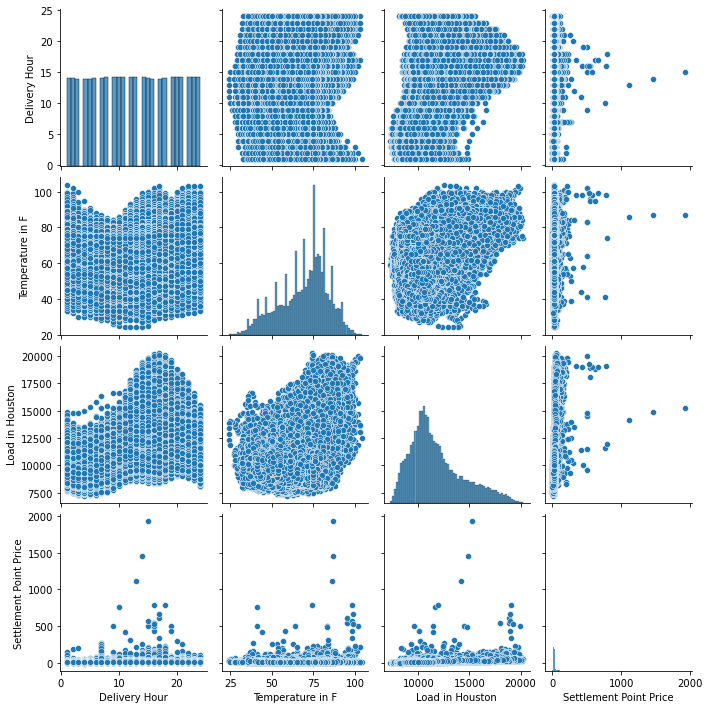

In [10]:
sns.pairplot(load)
plt.show()

In [11]:
# Removing "," from columns "Load in Houston" , "Ercot Load" and "Settlement Point Price"
load['Load in Houston'] = load['Load in Houston'].astype(str).str.replace(r',', '')
#load['Ercot Load'] = load['Ercot Load'].astype(str).str.replace(r',', '')
load['Settlement Point Price'] = load['Settlement Point Price'].astype(str).str.replace(r',', '')
load.head()

,Delivery Date,Delivery Hour,Repeated Hour Flag,Settlement Point Name,Settlement Point Type,DayStatus,Temperature in F,Load in Houston,Settlement Point Price
0,1/1/2015,1,N,LZ_HOUSTON,LZ,Public Holiday,44,9844.2,22.47
1,1/1/2015,2,N,LZ_HOUSTON,LZ,Public Holiday,44,9653.46,22.31
2,1/1/2015,3,N,LZ_HOUSTON,LZ,Public Holiday,44,9502.3,22.2
3,1/1/2015,4,N,LZ_HOUSTON,LZ,Public Holiday,44,9474.48,22.13
4,1/1/2015,5,N,LZ_HOUSTON,LZ,Public Holiday,44,9554.37,22.16


In [12]:
load['Settlement Point Price'] = load['Settlement Point Price'].astype(float)
load['Temperature in F'] = load['Temperature in F'].astype(float)
load['Load in Houston'] = load['Load in Houston'].astype(float)
#load['Ercot Load'] = load['Ercot Load'].astype(float)
load['Settlement Point Price'] = round(load['Settlement Point Price'],2)
load.dtypes
dataset = load.values

In [13]:
load.dtypes

import datetime
load['year'] = pd.DatetimeIndex(load['Delivery Date']).year
load['day'] = pd.DatetimeIndex(load['Delivery Date']).day# Extracting Day from "Delivery Date"
load['month'] = pd.DatetimeIndex(load['Delivery Date']).month   # Extracting Month from "Delivery Date"


a = load['Delivery Date']
a= pd.to_datetime(a)

load['dayofweek'] = a.dt.dayofweek
load['dayofweek']

0        3
1        3
2        3
3        3
4        3
        ..
34633    0
34634    0
34635    0
34636    0
34637    0
Name: dayofweek, Length: 34638, dtype: int64

In [14]:
load['year'] = pd.DatetimeIndex(load['Delivery Date']).year

In [15]:
load = load.set_index(['Delivery Date']) 
load = load.drop(columns=['year','day','Settlement Point Name','Settlement Point Type'], axis=1)  
# Re-arranging Columns
load = load[['dayofweek','month','Delivery Hour','Temperature in F','Load in Houston', 'Settlement Point Price']]
load.head()

,dayofweek,month,Delivery Hour,Temperature in F,Load in Houston,Settlement Point Price
Delivery Date,,,,,,
1/1/2015,3,1,1,44.0,9844.20,22.47
1/1/2015,3,1,2,44.0,9653.46,22.31
1/1/2015,3,1,3,44.0,9502.30,22.20
1/1/2015,3,1,4,44.0,9474.48,22.13
1/1/2015,3,1,5,44.0,9554.37,22.16


C:\Users\Abhishek\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


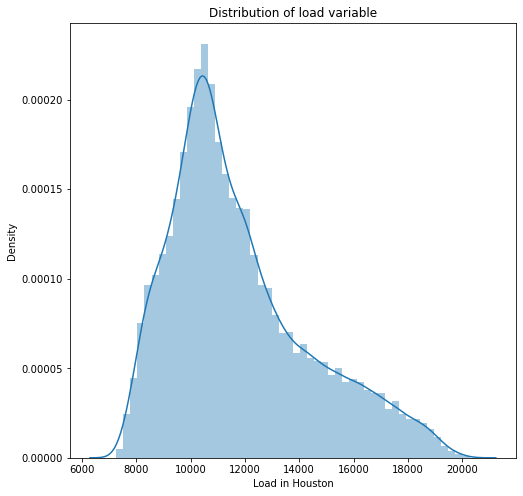

In [16]:
plt.figure(figsize=(8,8))
sns.distplot(load['Load in Houston'])
plt.xlabel("Load in Houston")
plt.title("Distribution of load variable")
plt.show()

C:\Users\Abhishek\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


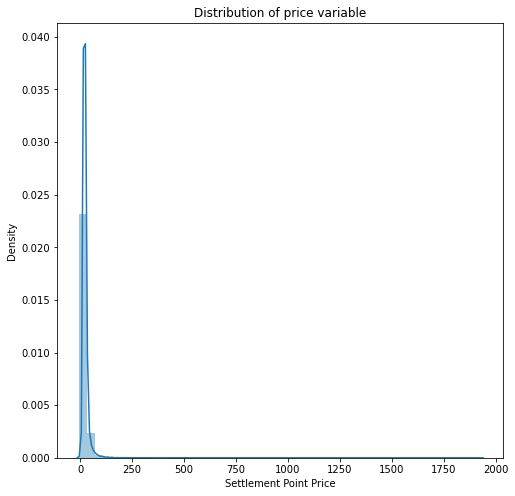

In [17]:
plt.figure(figsize=(8,8))
sns.distplot(load['Settlement Point Price'])
plt.xlabel("Settlement Point Price")
plt.title("Distribution of price variable")
plt.show()

As we can see our price variable heavily skewed and not much of insights can be gathered from the above plot. Hence we will use log transformation.

# Lets check the hour wise usage of power

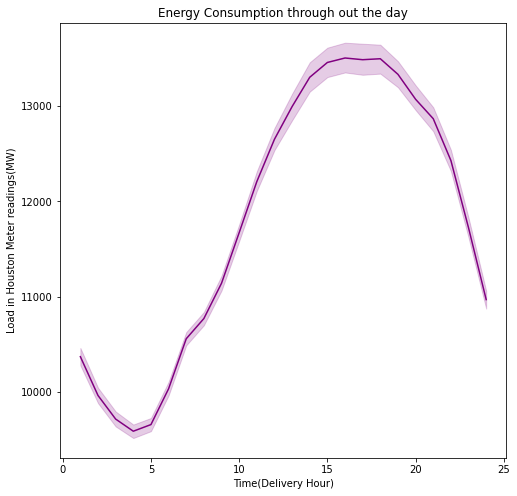

In [18]:
load['Load in Houston'] = pd.to_numeric(load['Load in Houston'], errors='coerce')

plt.figure(figsize=(8, 8))
hour_df = load.groupby(['Delivery Date', 'Delivery Hour'])['Load in Houston'].mean().reset_index()
sns.lineplot(x=hour_df['Delivery Hour'], y=hour_df['Load in Houston'], color='purple')
plt.xlabel("Time(Delivery Hour)")
plt.ylabel("Load in Houston Meter readings(MW)")
plt.title("Energy Consumption through out the day")
plt.show()

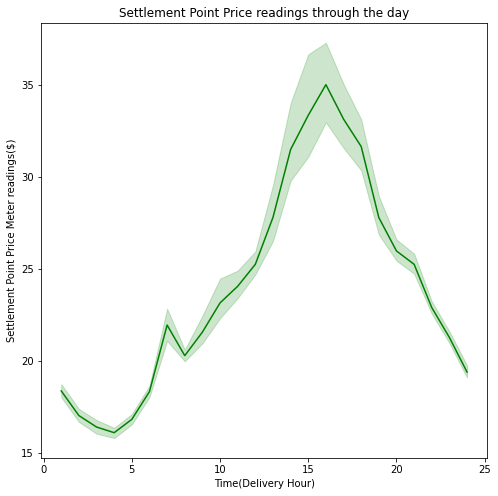

In [19]:
plt.figure(figsize=(8, 8))
hour_df = load.groupby(['Delivery Date', 'Delivery Hour'])['Settlement Point Price'].mean().reset_index()
sns.lineplot(x=hour_df['Delivery Hour'], y=hour_df['Settlement Point Price'], color='green')
plt.xlabel("Time(Delivery Hour)")
plt.ylabel("Settlement Point Price Meter readings($)")
plt.title("Settlement Point Price readings through the day")
plt.show()

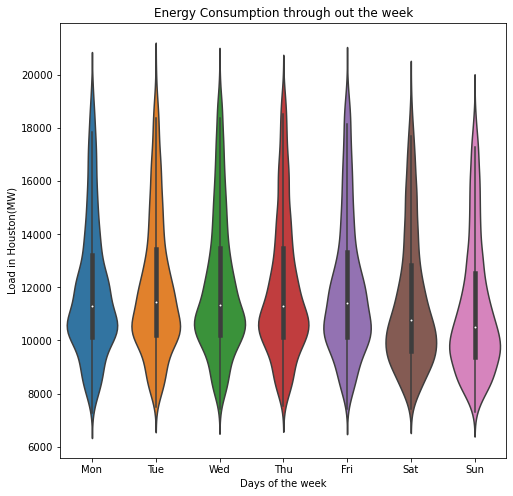

In [20]:
#Lets check the day wise usage of power
plt.figure(figsize=(8,8))
day_labels= ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
p=sns.violinplot(x=load['dayofweek'], y=load['Load in Houston'], pallete='muted')
p.set_xticklabels(day_labels)
plt.xlabel("Days of the week")
plt.ylabel("Load in Houston(MW)")
plt.title("Energy Consumption through out the week")
plt.show()

There is not much of a difference in day to day basis of usage. Still, sundays have the lowest usage as we know most of the companies and educational institutions are closed on sunday.

 # Average monthly usage

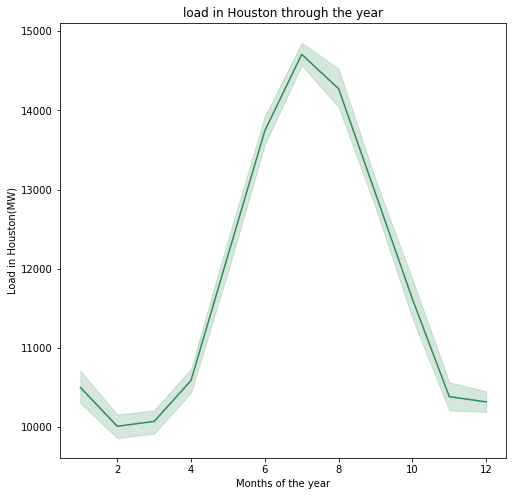

In [21]:
#Lets check the month wise usage of power
plt.figure(figsize=(8,8))
month_df= load.groupby(['Delivery Date','month'])['Load in Houston'].mean().reset_index()
sns.lineplot(x=month_df['month'], y=month_df['Load in Houston'], color='seagreen')
plt.xlabel("Months of the year")
plt.ylabel("Load in Houston(MW)")
plt.title("load in Houston through the year")
plt.show()

The average monthly consumption is minimal in the initial months and then rises after March in the onset of spring. It peaks in July and starts dropping again in the Autumn and winter months.

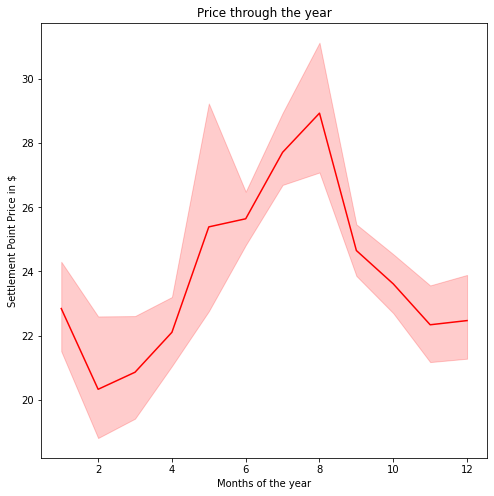

In [22]:
#Lets check the month wise usage of power
plt.figure(figsize=(8,8))
month_df= load.groupby(['Delivery Date','month'])['Settlement Point Price'].mean().reset_index()
sns.lineplot(x=month_df['month'], y=month_df['Settlement Point Price'], color='red')
plt.xlabel("Months of the year")
plt.ylabel("Settlement Point Price in $")
plt.title("Price through the year")
plt.show()

As we can that the price column is following a similar pattern of load in Houston.

# Lets check the Distribution Plot: Temperature

C:\Users\Abhishek\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


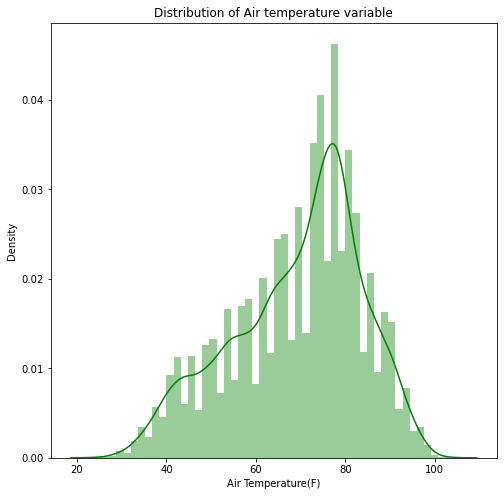

In [23]:
plt.figure(figsize=(8,8))
sns.distplot(load['Temperature in F'].dropna(), color='green')
plt.xlabel("Air Temperature(F)")
plt.title("Distribution of Air temperature variable")
plt.show()

The air temperature roughly follows a normal distribution. The maximum observations lie between 70-80 deg F.

### 3.12 Mean meter readings by air temperature

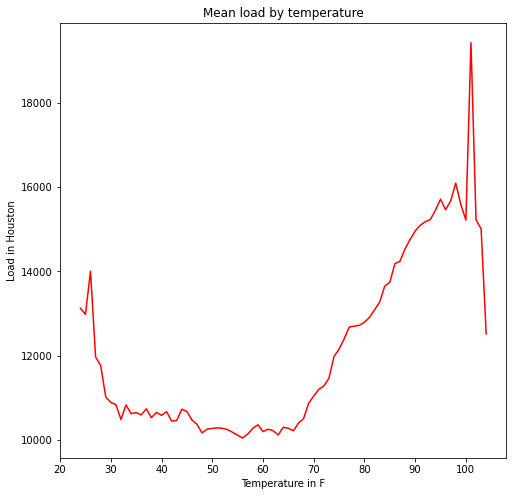

In [24]:
plt.figure(figsize=(8,8))
temp_df= load.groupby('Temperature in F')['Load in Houston'].mean().reset_index()
sns.lineplot(x=temp_df['Temperature in F'], y=temp_df['Load in Houston'], color='red')
plt.ylabel("Load in Houston")
plt.title("Mean load by temperature")
plt.show()

The average meter readings are high when the temperature is negative, once it starts increasing, the meter consumption reduces. It again spikes when the temperature rises above 70 deg F.

In [25]:
print(load[load['Load in Houston'] == load['Load in Houston'].max()])

               dayofweek  month  Delivery Hour  Temperature in F  \
Delivery Date                                                      
8/21/2018              1      8             17              74.0   

               Load in Houston  Settlement Point Price  
Delivery Date                                           
8/21/2018             20269.85                   56.79  


In [26]:
load.iloc[:1].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, 1/1/2015 to 1/1/2015
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   dayofweek               1 non-null      int64  
 1   month                   1 non-null      int64  
 2   Delivery Hour           1 non-null      int64  
 3   Temperature in F        1 non-null      float64
 4   Load in Houston         1 non-null      float64
 5   Settlement Point Price  1 non-null      float64
dtypes: float64(3), int64(3)
memory usage: 56.0+ bytes


In [27]:
#adding season features
load['season']= load['month'].apply(lambda x: 'Spring' if x==3 or x==4 or x==5 else 'Summer' if 
                                                x==6 or x==7 or x==8 
                                                else 'Autumn' if x==9 or x==10 or 
                                                x==11 else 'Winter')

In [28]:
#Adding day and night period features
load['IsDayTime']= load['Delivery Hour'].apply(lambda x: 1 if x >=6 and x <=18 else 0)

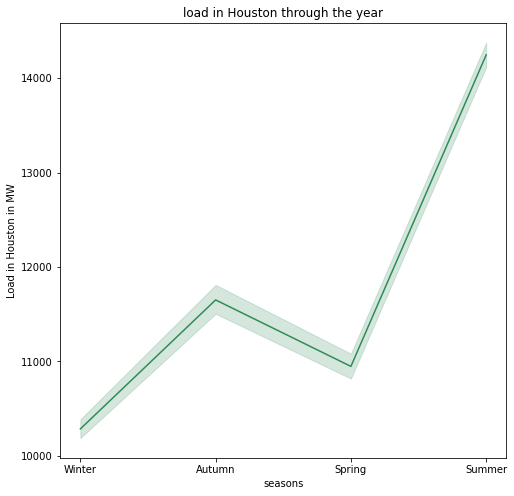

In [29]:
#Lets check the season wise usage of power
plt.figure(figsize=(8,8))
month_df= load.groupby(['Delivery Date','season'])['Load in Houston'].mean().reset_index()
sns.lineplot(x=month_df['season'], y=month_df['Load in Houston'], color='seagreen')
plt.xlabel("seasons")
plt.ylabel("Load in Houston in MW")
plt.title("load in Houston through the year")
plt.show()

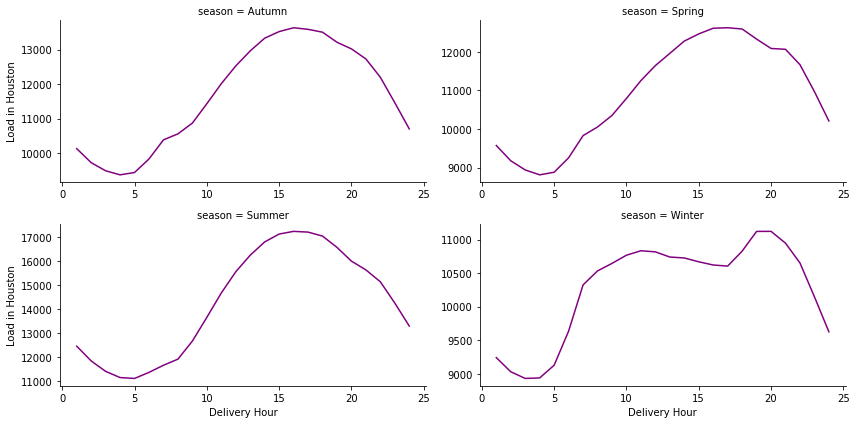

In [30]:
#Hourly average readings based on type of buildings
hour_use_df= load.groupby(['Delivery Hour', 'season'])['Load in Houston'].mean().reset_index()
p=sns.FacetGrid(hour_use_df, col='season', col_wrap=2, height=3, aspect=2, sharey=False, sharex=False)
p.map(sns.lineplot, 'Delivery Hour', 'Load in Houston', color='purple')
plt.show()

In [31]:
#Adding day and night period features
load['IsDayTime']= load['Delivery Hour'].apply(lambda x: 1 if x >=6 and x <=18 else 0)

Text(0.5, 1.0, 'Energy consumption during the day')

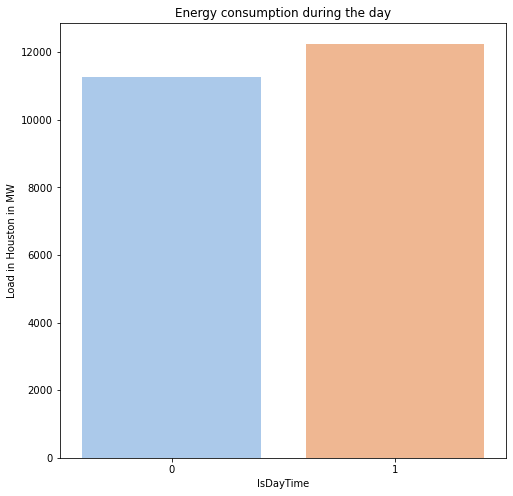

In [32]:

plt.figure(figsize=(8,8))
meter_df= load.groupby('IsDayTime')['Load in Houston'].mean().reset_index()
ax= sns.barplot(x='IsDayTime', y='Load in Houston', data=meter_df, palette='pastel')
plt.ylabel('Load in Houston in MW')
plt.title("Energy consumption during the day")

### Correlation Matrix

Text(0.5, 1.0, 'Correlation Matrix')

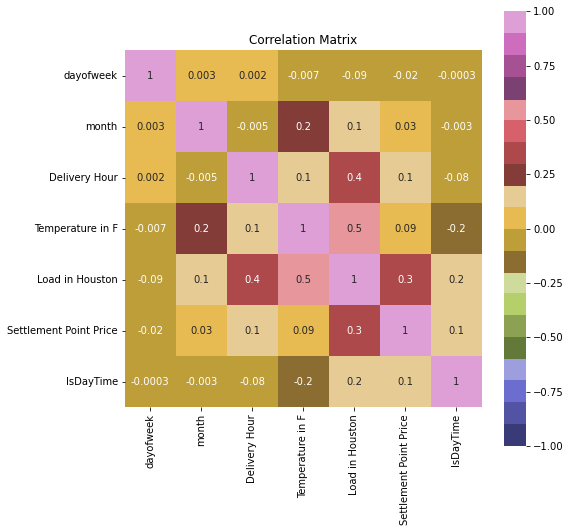

In [33]:
#Correlation Matrix
plt.figure(figsize=(8,8))
sns.heatmap(load.corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, square=True, cmap='tab20b')
plt.title('Correlation Matrix')

As we can see that Temperature and Load in Houston as positive correlation. Temperature plays a significant impact on the energy demand.

#  Feature Engineering

### Missing Value Imputation

In [35]:
#Check percentage of missing values in each column
def percent_missing_val(df):

  percent_missing = (df.isnull().sum() * 100) / len(df)
  missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
  return missing_value_df

In [36]:
missing_value_train= percent_missing_val(load)

In [37]:
missing_value_train

,column_name,percent_missing
dayofweek,dayofweek,0.0
month,month,0.0
Delivery Hour,Delivery Hour,0.0
Temperature in F,Temperature in F,0.0
Load in Houston,Load in Houston,0.0
Settlement Point Price,Settlement Point Price,0.0
season,season,0.0
IsDayTime,IsDayTime,0.0


No missing value 